## NLP Code

The purpose of this notebook is to generate the code that will be used to create a job applicaion tool.  Initially, the tool will accept a word document containing a job descrition as the input, from which the text will be decoded and analyzed.  The tool will provide two outputs: 

1. A visualization ranking the top 20 most frequently used words and phrases (phrases being bi- and tri-grams) within a given job description.  For this output, the tokens (words) will appear exactly as written in the job description - under the presumption that our resume will be screened by ATS software, it is important that the phrasing used is an identical match to that used by the employer.

2. A visualization ranking the top 20 most frequently used word stems within a given job description.  For this output, we want to view the job posting on a more macroscopic level, giving additional perspective to the skills and aptitudes most desired in a successful candidate.




This notebook is for writing the Natural Language Processing code that will go inside of the program function.
Requirements:
- tokenize text
- remove stop words
- stem tokens
- produce counts of most frequently used tokens and bi-grams

### Implementation Overview:
1. Import word document of job description
2. Generate stopword lists:  English list and custom list 
3. Apply tokenizer to strip puncuation, remove stopwords, and create bag of words
4. Create a dictionary of skills from word bag
5. Create a dictionary of stemmed skills from word bag
6. Create a third dictionary with counts of unstemmed words for each word stem
7. Visualize results 

#### Next Steps:
- Transpose second and third dictionaries into DataFrame
- Repeat processing for bi- and tri-grams*
- Update DataFrame with results of bi- and tri-grams analysis

**For bi- and tri-gram analysis, only remove English stopwords and omit results containing stemmed versions of custom stopwords.* 



In [74]:
# import relevant packages
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textract as tx
import nltk
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

# OUTPUT 1

## Step 1 - Generate Lists of Stopwords

Two lists two generate:  the first will be the standard English stopwords, the second will be a custom list of terms commonly found in job description headings and common verbs that do not add value to analysis.

### English Stopwords:

In [75]:
# Initialize the stemmers
porter = PorterStemmer()
lancaster = LancasterStemmer()
snowball = SnowballStemmer("english")

# download the nltk stopwords
# nltk.download('stopwords')

# assign english stop words to variable
eng_sw = stopwords.words('english')


### Custom Stopwords:

In [3]:
cust_sw = ["experience", "education", "skills", "responsibilities", "duties", "tasks",
           "overview", "candidate", "profile", "competencies", "benefits", "abilities",
           "description", "job description"]

### Full List of Stopwords:

In [4]:
stoppers = eng_sw
for i in cust_sw:
    stoppers.append(i)

## Step 2 - Transform Job Description Into List of Strings

The goal here is to isolate continous blocks of text by splitting the job description whenver a common text break is encountered.  The reason for doing so is that we don't want to create out-of-context ngrams where words did not appear as a continuous phrase in the job description.

Some caveats are required here:  hyphens, slashes and backslashes between words, and apostrophes should not be handled as text breaks, so they will be treated differently.  Hyphens, slashes, and backslashes will be replaced with a blank space, and apostrophes will simply be removed.

After handling the above cases, the text will be split into separate strings whenever one of the following is encountered in the job description:
- line break
- carriage return
- tab
- dash
- slash or backslash
- comma
- period
- semicolon
- colon
- parentheses
- exclamation mark
- question mark
- pipe

It is assumed at this point that bullets do not need to be considered, because each new bullet will be preceeded by a line break.  

It is reasonable to assume that text breaks may frequently appear concurrently within a job description, such as when bulleted points end in a period and are immediately followed by a line break.  Such occurrences will inherently result in blank or empy strings being encoded into the list of text strings.  After the text has been split, the list will be filtered to remove any blank or empty strings. 

In [5]:
# import word document and decode bytes into string data
text = tx.process("skills_sample.docx").decode("utf-8")

# substitute hyphens, slashes, and backslashes with a space
text = re.sub(r"(\S)[\-/\\](\S)", r"\1 \2", text)

# remove apostrophes 
text = re.sub(r"(\S)'(\S)", r"\1\2", text)

# split the text over common text breaks, creating a list of strings
parts = re.split(r'[\n\r\t\-\\/,.;:()!?|]', text)

# filter out any blank or empty strings from list
filtered_parts = [s for s in parts if s.strip()]

# return filtered list
filtered_parts

['Adaptability',
 ' Flexibility and adaptability to learn new tools',
 ' techniques',
 ' and technologies as needed to support evolving business needs',
 'Attention to Detail',
 ' Strong attention to detail and accuracy in data analysis and reporting to ensure the reliability and integrity of findings',
 'Strong problem solving',
 ' logical thinking and analytical skills',
 'Proficiency in\xa0computer skills\xa0including Excel',
 ' PowerPoint',
 ' and mapping software',
 'Statistical Knowledge',
 ' Solid understanding of statistical concepts and methods for data analysis',
 ' such as regression analysis',
 ' hypothesis testing',
 ' and time series analysis',
 'Communication Skills',
 ' Excellent verbal and written communication skills with the ability to effectively present findings and recommendations to both technical and non technical audiences',
 'Team Collaboration',
 ' Ability to work collaboratively in a cross functional team environment and effectively communicate with stakehol

In [6]:
# test
# text = "Description: This is a test, with 'comma's' - and periods (In the | text). \n\nAnd line breaks and/or hyphenated words like problem-solving"


## Step 3 - Tokenize the Text

With the job description text now split into a list of phrases, delineated by common text breaks, the next step is to tokenize each string phrase.  CountVectorizer will be used to accomplish this and since CountVectorizer accepts custom tokenizer functions, one has been defined to alleviate code complexity and enhance reproducibility.  The custom tokenizer removes any remaining punctuation (incl. line breaks, carriage returns, non-breaking spaces, and tabs), converts all text to lowercase, splits the strings into individual tokens, and removes all stop words and blank tokens (i.e., empty strings passed as tokens).

Note:  with stop words being removed, including the custom list defined above, it is realistic that some rows in the resulting matrix produced by CountVectorizer will contain no tokens.  For a sufficiently large document, this would be undesirable from a compute and memory standpoint.  For the scope of this application it is considered tolerable to have some blank rows; however, if this program were to be deployed on larger text documents, this issue should be addressed in the code.  

In [7]:
# custom tokenizer definition
def my_tokenizer(corpus):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        corpus = corpus.replace(punctuation_mark,'').lower()

    # remove all line breaks and non-breaking spaces
    corpus = re.sub(r'[\n\r\xa0\t]', ' ', corpus)

    # split string into words
    listofwords = corpus.split(' ')
    wordbag = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in stoppers) and (word!=''):
            wordbag.append(word)

    return wordbag

In [8]:
# a dummy sentence used for checking our process
#test_sent = "The quick brown fox, jumped over the lazy, lazy dog!!"

In [9]:
# # apply tokenizer
# bagofskills = unigram_tokenizer(job_corpus)
# print(bagofskills)

Use CountVectorizer function to matricize lists of tokens: `min_df` set to 1, `tokenizer` set to the custom tokenizer defined above, `ngram_range` includes a range of 1 to 3 so that bi- and tri-grams are also computed.

In [10]:
# instantiate a CountVectorizer with desired parameters
bagofskills = CountVectorizer(min_df=1,
                              tokenizer=my_tokenizer,
                              ngram_range=(1, 3))

# create sparse matrix of skills
skills_matrix = bagofskills.fit_transform(filtered_parts)

# transform sparse matrix into DataFrame
skills_df = pd.DataFrame(
    {"Frequency": skills_matrix.toarray().sum(axis=0)},  # remember the .sum() to get the total number of instances of word
    index=bagofskills.get_feature_names()
).sort_values("Frequency", ascending=True)

In [11]:
display(skills_df.tail(20))

,Frequency
ability effectively,1
findings recommendations,1
evolving business needs,1
adaptability,2
detail,2
attention,2
attention detail,2
technical,2
team,2
communication,2


## Step 4 - Visualize Results

Display the 20 most frequently occurring words and phrases from the job description.

**Note:  Once the stems are added to the df, need to specify the columns to use for x- and y-axes.

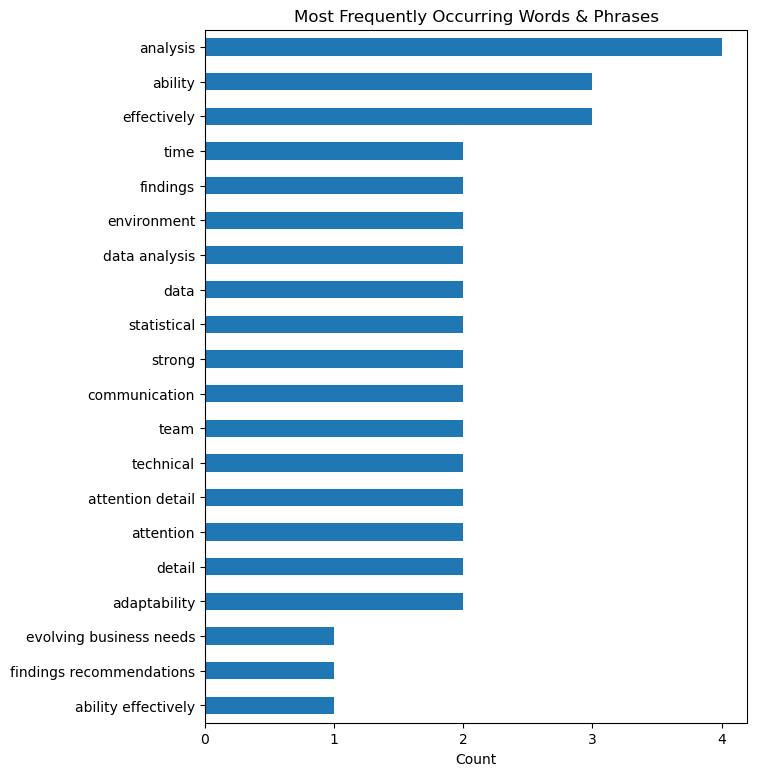

In [21]:
# get max value for skill frequency
max_val = skills_df["Frequency"].max()
# define xticks range based on max value
tick_range = np.arange(0, max_val+1, 1)

# plot horizontal bar graph
skills_df.tail(20).plot(kind="barh", figsize=(7, 9), legend=False)
plt.title("Most Frequently Occurring Words & Phrases")
plt.xlabel("Count")
plt.xticks(tick_range)
plt.show()

# OUTPUT 2

The second output is a visualization showing the most frequently occurring word stems in the document.  

## Step 1

Use CountVectorizer function to matricize lists of tokens: `min_df` set to 1, `tokenizer` set to the custom tokenizer defined above, `ngram_range` excluded here - we only care about unigram stems

In [86]:
# instantiate a CountVectorizer with desired parameters
bagofstems = CountVectorizer(min_df=1,
                              tokenizer=my_tokenizer)

# create sparse matrix of skills to be stemmed
stems_matrix = bagofstems.fit_transform(filtered_parts)

# transform sparse matrix into DataFrame
stems_df = pd.DataFrame(
    {"Skill Count": stems_matrix.toarray().sum(axis=0)},  # remember the .sum() to get the total number of instances of word
    index=bagofstems.get_feature_names()
).sort_values("Skill Count", ascending=True)

In [87]:
display(stems_df.tail(20))

,Skill Count
hypothesis,1
knowledge,1
evolving,1
including,1
integrity,1
environment,2
adaptability,2
time,2
attention,2
strong,2


In [88]:
test_df = stems_df.reset_index()
test_df.rename(columns={"index": "Skill"}, inplace=True)

test_df

,Skill,Skill Count
0,meeting,1
1,proficiency,1
2,problem,1
3,priorities,1
4,present,1
...,...,...
72,detail,2
73,technical,2
74,effectively,3
75,ability,3


In [89]:
test_df["Stem"] = test_df["Skill"].apply(lambda x: lancaster.stem(x))

test_df

,Skill,Skill Count,Stem
0,meeting,1,meet
1,proficiency,1,proficy
2,problem,1,problem
3,priorities,1,pri
4,present,1,pres
...,...,...,...
72,detail,2,detail
73,technical,2,techn
74,effectively,3,effect
75,ability,3,abl


In [91]:
test_df2 = test_df.copy()
test_df2["Stem Count"] = test_df2["Skill Count"]
test_df2

,Skill,Skill Count,Stem,Stem Count
0,meeting,1,meet,1
1,proficiency,1,proficy,1
2,problem,1,problem,1
3,priorities,1,pri,1
4,present,1,pres,1
...,...,...,...,...
72,detail,2,detail,2
73,technical,2,techn,2
74,effectively,3,effect,3
75,ability,3,abl,3


In [92]:
doodoo = test_df2.groupby(["Stem"])["Stem Count"].sum().reset_index()

doodoo_sorted = doodoo.sort_values(['Stem Count'], ascending=False).reset_index(drop=True)

doodoo_sorted

,Stem,Stem Count
0,analys,5
1,abl,3
2,commun,3
3,effect,3
4,techn,3
...,...,...
65,acc,1
66,new,1
67,non,1
68,org,1


In [93]:
last_df = test_df.merge(doodoo_sorted, how='outer', on='Stem')

In [94]:
last_df_sorted = last_df.sort_values(['Stem Count'], ascending=False).reset_index(drop=True)
last_df_sorted

,Skill,Skill Count,Stem,Stem Count
0,analysis,4,analys,5
1,analytical,1,analys,5
2,techniques,1,techn,3
3,communicate,1,commun,3
4,communication,2,commun,3
...,...,...,...,...
72,reporting,1,report,1
73,support,1,support,1
74,written,1,writ,1
75,proficiency,1,proficy,1


In [96]:
new_order = ["Stem", "Stem Count", "Skill", "Skill Count"]

stems_df = last_df_sorted[new_order]

stems_df

,Stem,Stem Count,Skill,Skill Count
0,analys,5,analysis,4
1,analys,5,analytical,1
2,techn,3,techniques,1
3,commun,3,communicate,1
4,commun,3,communication,2
...,...,...,...,...
72,report,1,reporting,1
73,support,1,support,1
74,writ,1,written,1
75,proficy,1,proficiency,1


In [116]:
stems_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Stem         77 non-null     object
 1   Stem Count   77 non-null     int64 
 2   Skill        77 non-null     object
 3   Skill Count  77 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 2.5+ KB


## Visualize Results

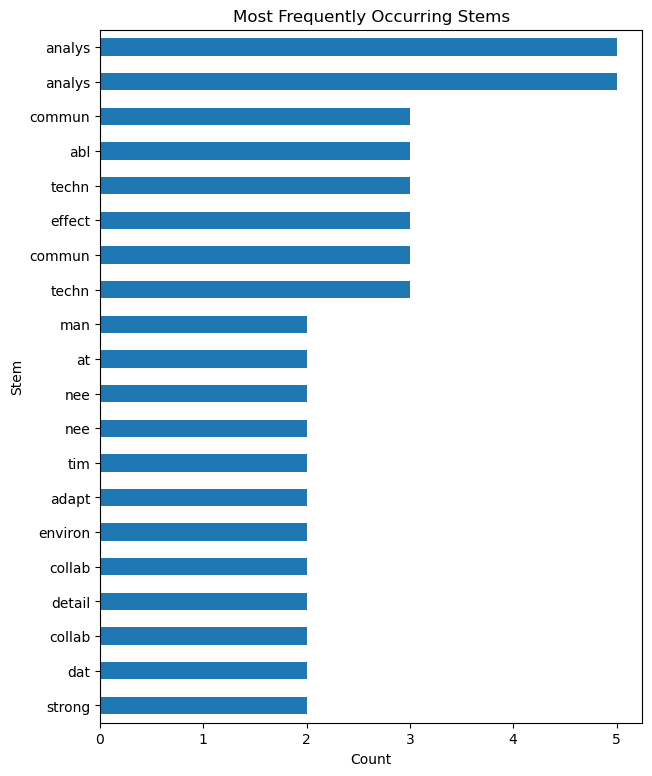

In [120]:
# get max value for skill frequency
max_val = stems_df["Stem Count"].max()
# define xticks range based on max value
tick_range = np.arange(0, max_val+1, 1)

# plot horizontal bar graph
stems_df.sort_values("Stem Count", ascending=True).tail(20).plot(x="Stem", y="Stem Count", kind="barh", figsize=(7, 9), legend=False)
plt.title("Most Frequently Occurring Stems")
plt.xlabel("Count")
plt.xticks(tick_range)
plt.show()

#### Testing Stemmers 

In [73]:
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer

# Initialize the stemmers
porter = PorterStemmer()
lancaster = LancasterStemmer()
snowball = SnowballStemmer("english")

# List of words to stem
words = ["analysis", "analyses", "analyze", "analyzed", "analytical"]

# Function to apply a stemmer to a list of words
def stem_words(stemmer, words):
    return [stemmer.stem(word) for word in words]

# Apply the stemmers and print results
print("Porter Stemmer results:", stem_words(porter, words))
print("Lancaster Stemmer results:", stem_words(lancaster, words))
print("Snowball Stemmer results:", stem_words(snowball, words))


Porter Stemmer results: ['analysi', 'analys', 'analyz', 'analyz', 'analyt']
Lancaster Stemmer results: ['analys', 'analys', 'analys', 'analys', 'analys']
Snowball Stemmer results: ['analysi', 'analys', 'analyz', 'analyz', 'analyt']
